# Problems 4 - Logistic Regression and Regularisation

## Logistic Regression


Here is the logistic regression gradient descent function we defined last time.

In [1]:
import numpy as np

def sigmoid(X):
    '''
    Computes the Sigmoid function of the input argument X.
    '''
    return 1.0/(1+np.exp(-X))


def GradientDescent_logistic(x,y,max_iterations=2500, alpha=0.1):
    
    m,n = x.shape # number of samples, number of features

    # y must be a column vector
    y = y.reshape(m,1)
    
    #initialize the parameters
    theta = np.ones(shape=(n,1)) 
    
    # Repeat until convergence (or max_iterations)
    for iteration in range(max_iterations):
        h = sigmoid(np.dot(x,theta))
        error = (h-y)
        gradient = np.dot(x.T , error) / m
        theta = theta - alpha*gradient
    return theta


def classifyVector(X, theta):
    '''
    Evaluate the Logistic Regression model h(x) with theta parameters,
    and returns the predicted label of x.
    '''
    prob = sigmoid(sum(np.dot(X,theta)))
    if prob > 0.5: return 1.0
    else: return 0.0

Let's load also the synthetic dataset we used last time and plot it.

(117, 2)
(117,)


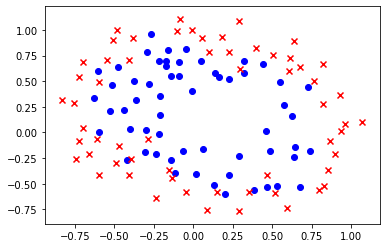

In [2]:
# Load the synthetic dataset

import pickle

with open('./P4data.pkl', 'rb') as f:
    (X,y) = pickle.load(f, encoding='latin1')

print (X.shape)
print (y.shape)

# Plot the data

%matplotlib inline 
import matplotlib.pyplot as plt

plt.scatter(X[y==1, 0], X[y==1, 1], marker='o', c='b') #positive samples
plt.scatter(X[y==0, 0], X[y==0, 1], marker='x', c='r') #negative samples
plt.show()

Finally, we redefine the function that maps the original features to polynomial terms up to degree $d$.

Important: we have made a change to normalise the new features.

$MapFeature(x_1, x_2, d) = [x_1,x_2,x_1^2,x_1x_2,x_2^2,x_1^3, \dots , x_1^d, x_2^d]$

In [3]:
def map_feature(x1, x2, mu=np.array([]), sigma=np.array([]), degree = 6):
    '''
    Maps 2D features to quadratic features.
    Returns a new feature vector with more features, comprising of
    x1, x2, x1^2, x2^2, x1*x2, x1*x2^2, etc...
    '''
    
    x1.shape = (x1.size, 1)
    x2.shape = (x2.size, 1)
    out = np.ones(shape=(x1[:, 0].size, 1))
    
    for i in range(1, degree + 1):
        for j in range(i + 1):
            r = (x1 ** (i - j)) * (x2 ** j)
            out = np.append(out, r, axis=1)

    # Normalise the newly created features
    if (len(mu)==0): #calculate the mu and sigmas
        mu = np.mean(out, 0) #calculate the mean for every column
        sigma = np.std(out, 0, ddof=1) #calculate the standard deviation for every column

    # Scale features and set them to zero mean (standarize)
    # normalize everything except X0 (the artificial first feature that we set to ones)
    for i in range(1, out.shape[1]):
        out[:,i] = (out[:,i] - mu[i]) / sigma[i];

    return (out, mu, sigma)

We will create more features from each data point. We will map the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power. As a result of this mapping, our vector of two features is transformed into a 28-D vector.

Then we can apply gradient descent to fit a logistic model on these new features.

Let's try to fit a polynomial of degree = 2

In [5]:
#Use our function to create new features up to degree 2
deg = 2
(features, m, s) = map_feature(X[:,0], X[:,1], degree=deg)
print(features.shape)

#Logistic Regression gradient descent optimization
w = GradientDescent_logistic(features, y, max_iterations=20000, alpha = 0.1)

H = [classifyVector(features[i,:],w) for i in range(features.shape[0])]
print ("Training Accuracy : {0}".format(str(float(np.sum(H == y)) / y.shape[0])))

(117, 6)
Training Accuracy : 0.8547008547008547


<a list of 1 text.Text objects>

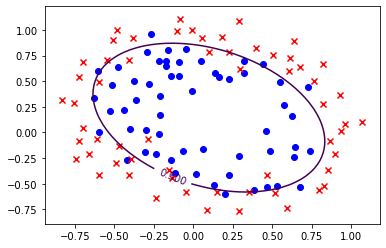

In [6]:
#Plot data
plt.scatter(X[y==1, 0], X[y==1, 1], marker='o', c='b') #positive samples
plt.scatter(X[y==0, 0], X[y==0, 1], marker='x', c='r') #negative samples

#Plot Boundary
u = np.linspace(np.min(X[:,0]), np.max(X[:,0]), 50)
v = np.linspace(np.min(X[:,1]), np.max(X[:,1]), 50)
z = np.zeros(shape=(len(u), len(v)))
for i in range(len(u)):
    for j in range(len(v)):
        z[i, j] = sigmoid(map_feature(np.array(u[i]),np.array(v[j]), mu=m, sigma=s, degree=deg)[0].dot(w))
        
z = z.T
cs = plt.contour(u, v, z, levels=[0.5])
plt.clabel(cs, inline=1, fontsize=10)


<font color=blue>Try generating a different number of features by changing the value of `deg` (e.g. features up to degree 1, 2, 3, ...15) and run the code above again for different degrees. What do you observe?

---

*Your answer here*

---


## Regularized Logistic Regression

Whether you have found the global minima in the previous exercise, or a very good training accuracy, it is probable that you are overfitting the classifier to this particular training data. If this is the case, the classifier is not going to perform well on unseen data examples.

Regularization is a technique to prevent overfitting.

In order to implement Regularized Logistic Regression we must change only the term of the partial derivative (the gradient) of the cost function:

$\frac{\partial}{\partial \theta_j} J(\theta) = {1 \over m} \sum_{i=1}^m{(h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)}}$.

which in the case of Regularized Logistic Regression is given by:

$\frac{\partial}{\partial \theta_j} J(\theta) = {1 \over m} \sum_{i=1}^m{(h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)}+{\lambda \over m}\theta_j}$

<font color=blue>Implement the Regularized Logistic Regression in Python.</font>

In [7]:
# Check the line you need to update, marked below

def GradientDescent_logistic_reg(x,y,max_iterations=2500, alpha=0.1, reg_lambda = 1):
    
    m,n = x.shape # number of samples, number of features

    # y must be a column vector
    y = y.reshape(m,1)
    
    #initialize the parameters
    theta = np.ones(shape=(n,1)) 
    
    # Repeat until convergence (or max_iterations)
    for iteration in range(max_iterations):
        h = sigmoid(np.dot(x,theta))
        error = (h-y)
        gradient = np.dot(x.T , error) / m  + reg_lambda * theta / m ### CHANGE THIS LINE
        theta = theta - alpha*gradient
    return theta

<font color=blue>Keep the number of features to 15, and try to call the above function with different values for $\lambda$ in order to avoid overfitting. What value of $\lambda$ works best?</font>

In [8]:
# YOUR CODE HERE


---

*Your answer here*

---
